In [2]:
import cv2 as cv
from dataclasses import dataclass
import matplotlib.pyplot as plt
from glob import glob
from scipy.optimize import curve_fit
import numpy as np

# Utils methods

## DFA Analysis
For defenition of crossovers we suggest to use the following functions based on ReLU function.

$$
f(x, R, C) = \frac{log(1 + e^{R (x - C)})*(x-C)}{R   \sqrt{1 + (x-C)^2}},
$$
where $R$ is coefficient which is proportonal to sharpness (rigidity) of a DFA crossover, $C$ is position of the crossover. And reversed version as follwing

$$
f_{rev}(x, R, C) = \frac{log(1 + e^{R (x - C)})(x-C)}{ - R   \sqrt{1 + (x-C)^2}},
$$

With this approach, when $x$ is too large, an overflaw may be detected in in exp. We will carry out transformations of the logarithm in function. 

$$
\mathrm{log}(1 + e^{x}) = 
\begin{cases}
x + \mathrm{log}(1 + e^{-x}) & \text{if } x > 0, \\
\mathrm{log}(1 + e^{x})      & \text{if } x \leq 0.
\end{cases}
$$

The expression $\log(1 + \exp(-|x|))$ is always numerically stable because $-|x| \leq 0$.

Based on this functions we defined the folling function $tf$ which can be ased as base element for fluctuation characteristic approximation.

$$
tf(x, R, C_1, C_2) = - f(x, R, C) - f_{rev}(x, R, C)
$$

### Single crossiver case

The single crossover case can be defined as following:

$$
y(x, R_{12}, C_{12}, S_1, S_2) = y_0 + x S_1 * tf(x, R_{12}, -100, C_{12}) + S_2 * tf(x, R_{12}, C_{12}, 100),
$$

where $y_0$ is function value if $x = 0$, $S_i$ is slope of $i$-th section of DFA, $C_{ij}$ is crossover possition between sections $i$ and $j$, $R_{ij}$ is sharpness of crossover between sections $i$ and $j$.

/var/folders/ss/dmcpgv8n4r57z4n2cpssxps80000gn/T/ipykernel_81294/1224021246.py:5: RuntimeWarning: overflow encountered in exp
  return np.log(1 + np.exp(R *(x - C))) / R * - (x-C) / np.sqrt(1 + (x-C)**2)


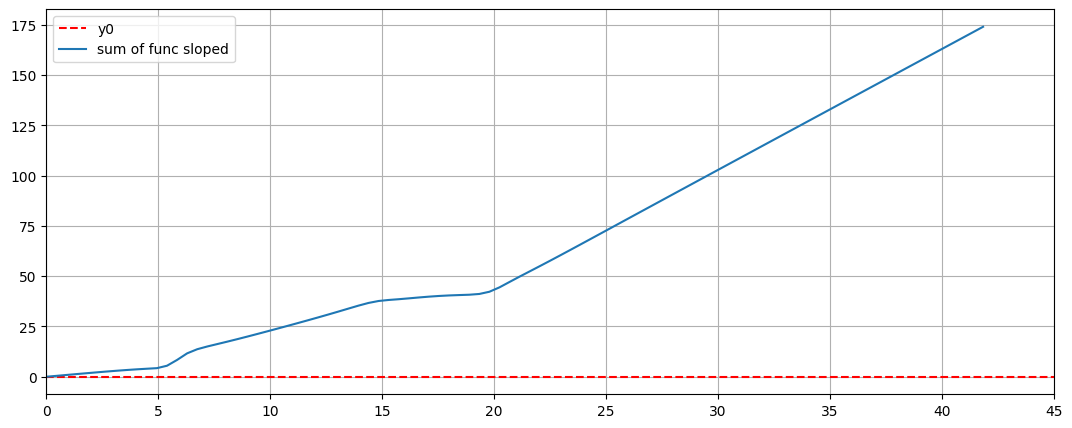

In [ ]:
def f_fcn(x, R, C):
    return np.log(1 + np.exp(R *(x - C))) / R * (x-C) / np.sqrt(1 + (x-C)**2)

def rev_f_fcn(x, R, C):
    return np.log(1 + np.exp(R *(x - C))) / R * - (x-C) / np.sqrt(1 + (x-C)**2)

def tf_minus_inf(x,R,C1):
    return rev_f_fcn(x,R,C1)

def tf_plus_inf(x,R,C2):
    return f_fcn(x,R,C2)

def tf(x, R, C1, C2):
    if C1<=float("-inf"):
        return tf_minus_inf(x,R,C1)
    elif C2>=float("inf"):
        return tf_plus_inf(x,R,C2)
    else:
        return - f_fcn(x, R, C2) - rev_f_fcn(x, R, C1)



def single_cross_fcn_sloped( x, y_0, C_12, slope_1, slope_2, R_12):
    # slope_value_minus=None
    # slope_value_minus=slope_1 * tf(C_12, R_12, -100, C_12)-slope_2 * tf(C_12, R_12, C_12, 100)
    # slope_value=None
    # slope_value_minus=None
    # slope_value_minus_array=[]
    # for i in range(x):
    #     slope_value= slope_1 * tf(i, R_12, -100, C_12)
    #     slope_value_minus=slope_value-(slope_1 * tf(C_12, R_12, -100, C_12))
    #     slope_value_minus_array+=slope_value-(slope_1 * tf(C_12, R_12, -100, C_12))

    # value_slope_1=slope_1 * (tf(x, R_12, -100, C_12)-tf(C_12, R_12, -100, C_12))
    # value_slope_2=slope_2 * tf(C_12, R_12, C_12, 100)
    value=None
    value=(slope_1*tf(0, R_12, -100, C_12))-(slope_2 * tf(0, R_12, C_12, 100))
    # value=(slope_1*tf(C_12, R_12, C_12, -100))-(slope_2 * tf(x, R_12, C_12, 100))
    func1=slope_1*(tf(x, R_12, -100, C_12))
    func2=slope_2 * tf(x, R_12, C_12, 100)
    return y_0+func1+func2-value


def multiple_cross_fcn_sloped(x, y_0, C_ij:np.ndarray, slope_ij: np.ndarray, R_ij:np.ndarray):
    prev_slope=None
    prev_R=None
    curr_C=None
    prev_C = -100
    value=None
    result_sloped=0

    result=np.zeros_like(x,dtype=float)
    for index in range(len(slope_ij)):
        slope=slope_ij[index]
        R=R_ij[index]
        if index<len(C_ij):
            curr_C=C_ij[index]
        else:
            curr_C=100
            pass
            # result+=slope*tf_plus_inf(x,R, curr_C)
            # # # curr_C = 100
        result+=slope*tf(x,R,prev_C,curr_C)
        result_sloped+=slope*tf(0, R, prev_C, curr_C)
        prev_C=curr_C
    return y_0+result-result_sloped

def single_cross_fcn(x, y_0, C_12, slope_1, slope_2, R_12):
    return y_0 \
        + slope_1 * tf(x, R_12, -100, C_12) \
        + slope_2 * tf(x, R_12, C_12, 100)
    



t = np.linspace(0, 45, num=101, endpoint=True)
y=np.linspace(-20, 100, num=101, endpoint=True)
slope_ij=[1,6,3,1,6]
C_ij=[5,6,15,20]
R_ij=[5,7,1,2,1]
slope_1=1
slope_2=0.5
fig, ax = plt.subplots()
fig.set_size_inches(13,5)
# plt.subplot(1,2,1)
# # slope_value=slope_y(t,0,5,slope_1,slope_2,1)
# plt.plot(t, -f_fcn(t, 1, 5), label="sigm_fcn")
# plt.plot(t, -rev_f_fcn(t, 1, -5), label="rev_sigm_fcn")
# plt.plot(t, tf(t, 1, -5, 5), label="summ")
# plt.grid(which='both')
# # ax.minorticks_on()
# plt.legend()

# plt.subplot(1,3,2)
# # plt.plot(t, y, label="const y0")
# plt.axhline(y=0, color='r', linestyle='--', label='y0')
# # plt.plot(t, (slope_1 * tf(t, 1, -100, 5))-((slope_1*tf(5, 1, -100, 5))-(slope_2 * tf(5, 1, 5, 100))), label="single_cross_fcn_slope1_down")
# plt.plot(t, (slope_1 * tf(t, 1, -100, 5)), label="single_cross_fcn_slope1")
# plt.plot(t, slope_2 * tf(t, 1, 5, 100), label="single_cross_fcn_slope2")
# plt.plot(t,single_cross_fcn_sloped(t,0,5,slope_1,slope_2,1),label='sum of func sloped')
# # plt.plot(t,single_cross_fcn(t,0,4,slope_1,slope_2,6),label='sum of func')

plt.subplot(1,1,1)
plt.axhline(y=0, color='r', linestyle='--', label='y0')
plt.plot(t,multiple_cross_fcn_sloped(t,0,C_ij,slope_ij,R_ij),label='sum of func sloped')

plt.grid()
# ax.minorticks_on()
plt.legend()

plt.xlim(0, 45)
plt.show()

for example, plot a function with the following paarameters: $y_0 = 0$, $C_{12} = 50$, $S_1 = 2$, $S_2 = 1$, $R_{12} = 1$ and $R_{12} = 10$ 

/var/folders/ss/dmcpgv8n4r57z4n2cpssxps80000gn/T/ipykernel_81294/531146652.py:5: RuntimeWarning: overflow encountered in exp
  return np.log(1 + np.exp(R *(x - C))) / R * - (x-C) / np.sqrt(1 + (x-C)**2)


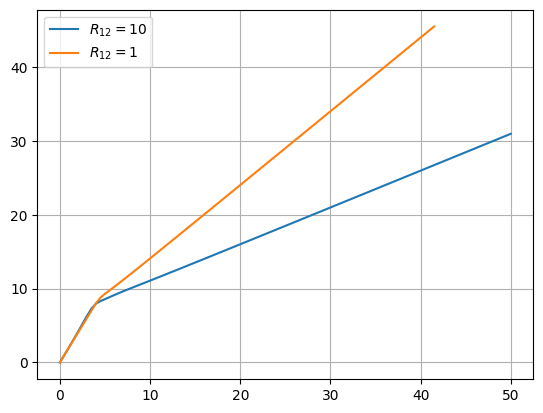

In [233]:
def plot_single_cross_example():
    intercept = 0 
    C_12 = 4
    C_23=10
    slope_1 = 2
    slope_2 = 1
    R_12=5
    R_23=5
    x = np.linspace(0, 50, num=101, endpoint=True)
    # y_01 = single_cross_fcn(x, intercept, C_12, slope_1, slope_2, 0.1)
    # y_1 = single_cross_fcn(x, intercept, C_12, slope_1, slope_2, 1,1,C_23)
    y_10 = single_cross_fcn_sloped(x, intercept, C_12, slope_1, 0.5, 1)
    y_sev_c=single_cross_fcn_sloped(x,intercept,C_12,slope_1,slope_2,R_12)
    y_test=tf(x,R_12,C_12,C_23)
    
    fig, ax = plt.subplots()
    # plt.plot(x, y_01, label="$R_{12} = 0.1$")
    # plt.plot(x, y_1 , label="$R_{12} = 1$")
    plt.plot(x, y_10 , label="$R_{12} = 10$")
    plt.plot(x,y_sev_c, label="$R_{12} = 1$")
    # plt.plot(x,y_test, label="several crossovers")
    plt.grid(which='both')
    # ax.minorticks_on()
    plt.legend()
    # plt.xlim(3, 6)
    plt.show()
plot_single_cross_example()

In [142]:
@dataclass
class var_estimation:
    value: float
    stderr: float

@dataclass
class dfa_params:
    intercept: var_estimation
    cross: var_estimation
    slope_l: var_estimation
    slope_h: var_estimation
    rigidity:var_estimation

In [1]:
def analyse_dfa(hs, S):
    """
    hs: array_like The independent variable where the data is measured. Should usually be an M-length sequence or an (k,M)-shaped array for functions with k predictors, and each element should be float convertible if it is an array like object.
    S: array_like The dependent data, a length M array.
    """
    s = np.repeat(S[:,np.newaxis], hs.shape[0], 1).T
    assert s.shape == hs.shape, f"Shape of x and y must be equal, but {s.shape} and {hs.shape}"
    (intercept, cross, slope_l, slope_h, rigidity), pcov, infodict, mesg, ier = curve_fit(single_cross_fcn, 
                                                           np.log10(s.flatten()), 
                                                           np.log10(hs.flatten()), 
                                                           p0=(0,np.log10(S[len(S)//2]), 1, 1, 5),
                                                           bounds=([-np.inf, np.log10(S[0]), 0, 0, 1],
                                                                   [+np.inf, np.log10(S[-1]), 5, 5, +np.inf]),
                                                            full_output=True)
    
    return dfa_params(
        intercept=var_estimation(value=intercept, stderr=np.sqrt(pcov[0][0])),
        cross=var_estimation(value=10**cross, stderr=np.sqrt(pcov[1][1])),
        slope_l=var_estimation(value=slope_l, stderr=np.sqrt(pcov[2][2])),
        slope_h=var_estimation(value=slope_h, stderr=np.sqrt(pcov[3][3])),
        rigidity=var_estimation(value=rigidity, stderr=np.sqrt(pcov[4][4]))
    ), 10**single_cross_fcn(np.log10(S), intercept, cross, slope_l, slope_h, rigidity) - hs

def plot_analyse_dfa(hs, S, params:dfa_params, residuals:np.ndarray, title="F(S)"):
    if len(residuals.shape) == 1:
        residuals = np.expand_dims(residuals, -1)
        
    #
    n_sigm = 3
    cross = params.cross.value
    print(f"Opt S = {params.cross.value}; H_l(S) = {params.slope_l.value}; H_h(S) = {params.slope_h.value}; y_0 = {params.intercept.value} ")
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_title(title)
    
    print(np.std(residuals, axis=0))
    ax.errorbar(S, 
                 10**(single_cross_fcn(np.log10(S), 
                                params.intercept.value, 
                                np.log10(params.cross.value), 
                                params.slope_l.value, 
                                params.slope_h.value,
                                params.rigidity.value)), 
                fmt='g--',
                capsize=7,
                yerr=2*np.std(residuals, axis=0),
                label=f"$H(S) \pm 2 \sigma$")
    
    # print(np.std(residuals, axis=-1))
    S = np.repeat(S[:,np.newaxis], hs.shape[0], 1).T
    
    regr_l =  10**(params.intercept.value+params.slope_l.value*np.log10(S))
    # regr_l_upper_bound =  10**(params.intercept.value+params.slope_l.value*np.array(np.log10(S))+n_sigm*params.slope_l.stderr)
    # regr_l_lower_bound =  10**(params.intercept.value+params.slope_l.value*np.array(np.log10(S))-n_sigm*params.slope_l.stderr)
    
    ax.plot(S[S<=cross], hs[S<=cross], '.', color='blue', label=f"$H_l(S) \sim {params.slope_l.value:.2f} \pm {2*params.slope_l.stderr:.2f} S$")
    
    # ax.plot(S, regr_l, lw=1, label=f'$H_l(S) = {params.slope_l.value:.2f}, S<{cross:.2f}$', color='blue', ls='--')
    # plt.fill_between(S, regr_l_lower_bound, regr_l_upper_bound, facecolor='blue', alpha=0.25,
    #         label=f'${n_sigm} \sigma(H_l(S))$')


    regr_h =  regr_l[S<=cross][-1] + 10**(params.intercept.value+params.slope_h.value*np.log10(S))
    
    # regr_h_upper_bound =  10**(params.intercept.value+params.slope_h.value*np.array(np.log10(S))+n_sigm*params.slope_h.stderr)
    # regr_h_lower_bound =  10**(params.intercept.value+params.slope_h.value*np.array(np.log10(S))-n_sigm*params.slope_h.stderr)
    
    
    ax.plot(S[S>cross], hs[S>cross], '.', color='red', label=f"$H_h(S)  \sim {params.slope_h.value:.2f} \pm {2*params.slope_h.stderr:.2f} S$")
    # ax.plot(S, regr_h, lw=1, label=f'$H_h(S) = {params.slope_h.value:.2f}, S>={cross:.2f}$', color='red', ls='--')
    # plt.fill_between(S, regr_h_lower_bound, regr_h_upper_bound, facecolor='red', alpha=0.25,
    #         label=f'${n_sigm} \sigma(H_l(S))$')

    ax.axvline(params.cross.value, label=f"Cross, $S = {params.cross.value:.2f} \pm {params.cross.stderr:.2f}$")
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(which='both')
    ax.legend()
    plt.plot()
    
    


tst_s = np.array([0.01, 0.1, 0.3, 0.5, 1, 1.5, 2.5, 5, 7.5, 10, 15, 20, 50, 100, 250, 500, 1000])
# tst_h = np.zeros_like(tst_s)
tst_cross = 5
# tst_h[:tst_cross] = 10**(2*np.array(np.log10(tst_s[:tst_cross])))
# tst_h[tst_cross:] = tst_h[tst_cross-1] + 10**(1*np.array(np.log10(tst_s[tst_cross:])))

tst_h = 10**single_cross_fcn(np.log10(tst_s), 0, np.log10(tst_cross), 1, 0.5, 1)

tst_hr = 1 + np.random.normal(0, 0.3, (20, len(tst_h)))
tst_hr *= tst_h



# plt.figure()
# plt.plot(tst_s, tst_hr)
# plt.xscale('log')
# plt.yscale('log')
# plt.grid(which='both')
# plt.show()

params, residuals  = analyse_dfa(tst_hr, tst_s)

plot_analyse_dfa(tst_hr, tst_s, params, residuals)

<>:47: SyntaxWarning: invalid escape sequence '\p'
<>:56: SyntaxWarning: invalid escape sequence '\s'
<>:56: SyntaxWarning: invalid escape sequence '\p'
<>:69: SyntaxWarning: invalid escape sequence '\s'
<>:69: SyntaxWarning: invalid escape sequence '\p'
<>:74: SyntaxWarning: invalid escape sequence '\p'
<>:47: SyntaxWarning: invalid escape sequence '\p'
<>:56: SyntaxWarning: invalid escape sequence '\s'
<>:56: SyntaxWarning: invalid escape sequence '\p'
<>:69: SyntaxWarning: invalid escape sequence '\s'
<>:69: SyntaxWarning: invalid escape sequence '\p'
<>:74: SyntaxWarning: invalid escape sequence '\p'
/var/folders/ss/dmcpgv8n4r57z4n2cpssxps80000gn/T/ipykernel_53797/2758061673.py:47: SyntaxWarning: invalid escape sequence '\p'
  label=f"$H(S) \pm 2 \sigma$")
/var/folders/ss/dmcpgv8n4r57z4n2cpssxps80000gn/T/ipykernel_53797/2758061673.py:56: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(S[S<=cross], hs[S<=cross], '.', color='blue', label=f"$H_l(S) \sim {params.slope_l.value:.2f

NameError: name 'dfa_params' is not defined